**Set up**

In [1]:
!pip3 install xgboost

  Using cached xgboost-1.6.0-py3-none-manylinux2014_x86_64.whl (193.7 MB)


In [2]:
# General purpose imports
import pandas as pd
import numpy as np
import collections

In [3]:
# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

**Dataset load & feature engineering**

In [4]:
# To retrieve dataset
from google.cloud import bigquery

In [5]:
client = bigquery.Client()

In [6]:
query = """
    SELECT *
    FROM packlink-bi.ml_ai_datasets.churn_classifier_sample_20220422
    """

In [7]:
results = client.query(query)

In [8]:
dataset_df = results.to_dataframe()

In [9]:
# Features
dataset_df.columns

Index(['user_id', 'platform', 'market_country', 'user_creation_datetime',
       'confirmation_datetime', 'first_purchase_datetime',
       'last_purchase_datetime', 'first_integration_datetime',
       'last_segment_recorded', 'longevity', 'total_sales',
       'avg_sales_per_day', 'min_days_btwn_sales',
       'frst_quartile_days_btwn_sales', 'avg_days_btwn_sales',
       'median_days_btwn_sales', 'thrd_quartile_days_btwn_sales',
       'max_days_btwn_sales', 'min_days_btwn_sale_date',
       'fst_quartile_days_btwn_sale_date', 'avg_days_btwn_sale_date',
       'median_days_btwn_sale_date', 'thrd_quartile_days_btwn_sale_date',
       'frequency', 'recency', 'month_label_count', 'quarter_label_count',
       'year_label_count', 'previous_year_label_count', 'historic_label_count',
       'month_revenue_eur', 'quarter_revenue_eur', 'year_revenue_eur',
       'previous_year_revenue_eur', 'historic_revenue_eur',
       'month_average_order_value', 'quarter_aov', 'year_aov',
       'year_p

In [10]:
# Check types
dataset_df.dtypes

user_id                                           object
platform                                          object
market_country                                    object
user_creation_datetime               datetime64[ns, UTC]
confirmation_datetime                datetime64[ns, UTC]
first_purchase_datetime              datetime64[ns, UTC]
last_purchase_datetime               datetime64[ns, UTC]
first_integration_datetime           datetime64[ns, UTC]
last_segment_recorded                             object
longevity                                          int64
total_sales                                        int64
avg_sales_per_day                                float64
min_days_btwn_sales                                int64
frst_quartile_days_btwn_sales                      int64
avg_days_btwn_sales                                int64
median_days_btwn_sales                             int64
thrd_quartile_days_btwn_sales                      int64
max_days_btwn_sales            

In [11]:
# Assign correct types to incorrect type columns
cols = ["month_revenue_eur", "quarter_revenue_eur", "year_revenue_eur",
        "previous_year_revenue_eur", "historic_revenue_eur", "month_average_order_value",
        "quarter_aov", "year_aov", "year_plat_cntry_aov", "previous_year_aov",
        "previous_year_plat_cntry_aov", "historic_aov"]
dataset_df[cols] = dataset_df[cols].astype('float64')

In [12]:
# Create has_integration column from integration datetime
dataset_df["has_integration"] = dataset_df["first_integration_datetime"].notna()

In [13]:
# Columns to drop for training
cols = ["user_id", "user_creation_datetime", "confirmation_datetime", "first_purchase_datetime",
        "last_purchase_datetime", "first_integration_datetime", "churn_factor"]
dataset_df.drop(cols, axis=1, inplace=True)

In [14]:
# Fill null values with 0
fillnan_w_0 = ["min_days_btwn_sale_date", "fst_quartile_days_btwn_sale_date",
               "avg_days_btwn_sale_date", "median_days_btwn_sale_date",
               "thrd_quartile_days_btwn_sale_date", "previous_year_label_count",
               "previous_year_revenue_eur", "previous_year_aov",
               "previous_year_plat_cntry_aov", "csat", "cs_tickets_good",
               "cs_tickets_offered", "cs_tickets_unoffered", "cs_tickets_bad",
               "customer_feedback_tickets", "total_tickets"]

dataset_df[fillnan_w_0] = dataset_df[fillnan_w_0].fillna(0, axis=0)

In [15]:
# Check no more null values
dataset_df.isna().sum()

platform                             0
market_country                       0
last_segment_recorded                0
longevity                            0
total_sales                          0
avg_sales_per_day                    0
min_days_btwn_sales                  0
frst_quartile_days_btwn_sales        0
avg_days_btwn_sales                  0
median_days_btwn_sales               0
thrd_quartile_days_btwn_sales        0
max_days_btwn_sales                  0
min_days_btwn_sale_date              0
fst_quartile_days_btwn_sale_date     0
avg_days_btwn_sale_date              0
median_days_btwn_sale_date           0
thrd_quartile_days_btwn_sale_date    0
frequency                            0
recency                              0
month_label_count                    0
quarter_label_count                  0
year_label_count                     0
previous_year_label_count            0
historic_label_count                 0
month_revenue_eur                    0
quarter_revenue_eur      

In [16]:
# reorder cols to ease array management
cols = ['longevity',
       'total_sales', 'avg_sales_per_day', 'min_days_btwn_sales',
       'frst_quartile_days_btwn_sales', 'avg_days_btwn_sales',
       'median_days_btwn_sales', 'thrd_quartile_days_btwn_sales',
       'max_days_btwn_sales', 'min_days_btwn_sale_date',
       'fst_quartile_days_btwn_sale_date', 'avg_days_btwn_sale_date',
       'median_days_btwn_sale_date', 'thrd_quartile_days_btwn_sale_date',
       'frequency', 'recency', 'month_label_count', 'quarter_label_count',
       'year_label_count', 'previous_year_label_count', 'historic_label_count',
       'month_revenue_eur', 'quarter_revenue_eur', 'year_revenue_eur',
       'previous_year_revenue_eur', 'historic_revenue_eur',
       'month_average_order_value', 'quarter_aov', 'year_aov',
       'year_plat_cntry_aov', 'previous_year_aov',
       'previous_year_plat_cntry_aov', 'historic_aov', 'csat',
       'cs_tickets_good', 'cs_tickets_offered', 'cs_tickets_unoffered',
       'cs_tickets_bad', 'customer_feedback_tickets', 'total_tickets',
       'platform', 'market_country', 'last_segment_recorded', 'has_integration', 'status']
dataset_df = dataset_df[cols]
# df to array
dataset_array = dataset_df.values
binary_features = dataset_array[:, -2:]
discrete_features = dataset_array[:, -5:-2]
continuous_features = dataset_array[:, :40]

In [17]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [18]:
# continuos features -> standard scaler
standar_scaler = StandardScaler()
standar_scaler.fit(continuous_features)
standarized_features = standar_scaler.transform(continuous_features)

# categorical binary -> ordinal encoder
ordinal_enc = OrdinalEncoder()
ordinal_enc.fit(binary_features)
print(ordinal_enc.categories_)
ordinal_features = ordinal_enc.transform(binary_features)

# categorical discrete -> 1 hot encoder
one_hot_enc = OneHotEncoder()
one_hot_enc.fit(discrete_features)
print(one_hot_enc.categories_)
one_hot_features = one_hot_enc.transform(discrete_features).toarray()

[array([False, True], dtype=object), array(['churned', 'ok'], dtype=object)]
[array(['COM', 'EBAY', 'PRO'], dtype=object), array(['DE', 'ES', 'FR', 'GB', 'IE', 'IT', 'UN'], dtype=object), array(['L', 'M', 'Non-recurring', 'S', 'XL', 'XL1', 'XXL'], dtype=object)]


In [19]:
# training dataset
X = np.hstack((standarized_features, one_hot_features))
X = np.hstack((X, ordinal_features))

In [20]:
X.shape

(51907, 59)

**Train / test split**

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
XX_train, XX_test = train_test_split(X, test_size=0.2)

In [23]:
X_train = XX_train[:, :-1]
y_train = XX_train[:, -1]
X_test = XX_test[:, :-1]
y_test = XX_test[:, -1]

In [24]:
X_train.shape

(41525, 58)

**Feed fordward NN configuration**

In [25]:
# https://github.com/naomifridman/Neural-Network-Churn-Prediction
# For Keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
import keras.optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
        
# as Function: for use in Keras Scikit lear wrapper
def churn_nn_classifier(meta, lsize=128):
        n_features_in_ = meta["n_features_in_"]
        
        model = Sequential()
        model.add(Input(shape=(n_features_in_,)))
        model.add(Dense(lsize, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(rate=0.25))
        model.add(Dense(int(lsize/2), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(rate=0.25))
        model.add(Dense(int(lsize/4), kernel_regularizer=regularizers.l2(0.1), activation='relu'))
        model.add(Dropout(rate=0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
        return model
    
def drow_history_acc(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def drow_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [26]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

  Using cached scikeras-0.7.0-py3-none-any.whl (27 kB)


In [27]:
from scikeras.wrappers import KerasClassifier

In [28]:
# Callbacks setup
checkpointer = ModelCheckpoint(filepath="churn_nn_model.h5", verbose=0, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2,patience=1, min_lr=0.0001)
reduce_val_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, patience=1, min_lr=0.0001)
es = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')

callbacks_list = [es, reduce_lr, reduce_val_lr, checkpointer]

In [30]:
# Scikitlearn wrapper config
skNN = KerasClassifier(model=churn_nn_classifier,
                       epochs=10,
                       batch_size=1026,
                       verbose=1,
                       fit__validation_data=None,
                       callbacks=callbacks_list)

**Logistic regressor classfier**

In [31]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(n_jobs=-1)

**Random Forest classifier**

In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_jobs=-1)

**XGBoost classifier**

In [33]:
# https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97
from xgboost import XGBClassifier

XGboost = XGBClassifier(n_jobs=-1)

**Training**

**Training strategy: stratified k-fold**

In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/compose.html#pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

def avg_ensemble_train(models, Xtrain, ytrain, Xval, yval):
    
    model_kfold_result = []
    ensemble_prob_pred = np.zeros((yval.shape[0], 2))
    ensemble_acc = 0

    for model_type, model in models:
        print(f"Training {model_type}...")
        if isinstance(model, KerasClassifier):
            model.fit(Xtrain, ytrain, validation_data=(Xval, yval))
        else:
            model.fit(Xtrain, ytrain)
        y_pred_fold = model.predict(Xval)
        y_probpred_fold = model.predict_proba(Xval) # binary class; to check to which one it corresponds check model.classes_
        fold_accuracy = accuracy_score(y_pred_fold, yval)
        model_kfold_result.append((model_type, y_pred_fold, y_probpred_fold, fold_accuracy))
        ensemble_prob_pred += y_probpred_fold
        ensemble_acc += fold_accuracy

    ensemble_prob_pred /= len(models)
    ensemble_pred = np.argmax(ensemble_prob_pred, axis=1)
    ensemble_acc /= len(models)
    
    return ensemble_pred, ensemble_prob_pred, ensemble_acc, model_kfold_result


def avg_ensemble_predict(models, X):
    ensemble_prob_pred = np.zeros((X.shape[0], 2))

    for model_type, model in models:
        y_probpred_fold = model.predict_proba(X) # binary class; to check to which one it corresponds check model.classes_
        ensemble_prob_pred += y_probpred_fold

    ensemble_prob_pred /= len(models)
    ensemble_pred = np.argmax(ensemble_prob_pred, axis=1)
    
    return ensemble_pred, ensemble_prob_pred


def skfold_train_avg_ensemble(models, X, y, n_splits=5):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    fold_results = []
    training_acc = 0
    i = 0
    
    for train_idx, val_idx in skfold.split(X, y):
        x_train_fold, x_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        
        print(f"Fold {i}:")
        result = avg_ensemble_train(models, x_train_fold, y_train_fold, x_val_fold, y_val_fold)
        ensemble_pred, ensemble_prob_pred, ensemble_acc, model_kfold_result = result
    
        fold_results.append((ensemble_pred, ensemble_prob_pred, ensemble_acc, model_kfold_result))
        training_acc += ensemble_acc
        
        i += 1
    
    training_pred = np.concatenate([fold[0] for fold in fold_results])
    training_prob_pred = np.concatenate([fold[1] for fold in fold_results])
    training_acc /= n_splits
    
    return training_acc, training_pred, training_prob_pred, fold_results


**Ensemble config 1: LR, XGBoost, RF**

In [35]:
e1_lr = LogisticRegression(n_jobs=-1)
e1_rf = RandomForestClassifier(n_jobs=-1)
e1_xgboost = XGBClassifier(n_jobs=-1)

e1_result = skfold_train_avg_ensemble([("lr", e1_lr), ("xgb", e1_xgboost), ("rf", e1_rf)], X_train, y_train)

Fold 0:
Training lr...
Training xgb...
Training rf...
Fold 1:
Training lr...
Training xgb...
Training rf...
Fold 2:
Training lr...
Training xgb...
Training rf...
Fold 3:
Training lr...
Training xgb...
Training rf...
Fold 4:
Training lr...
Training xgb...
Training rf...


**Ensemble config 2: LR, RF, NN**

In [37]:
e2_lr = LogisticRegression(n_jobs=-1)
e2_rf = RandomForestClassifier(n_jobs=-1)
e2_sknn = KerasClassifier(model=churn_nn_classifier,
                          epochs=10,
                          batch_size=1026,
                          verbose=0,
                          fit__validation_data=None,
                          callbacks=callbacks_list)

e2_result = skfold_train_avg_ensemble([("lr", e2_lr), ("rf", e2_rf), ("nn", e2_sknn)], X_train, y_train)

Fold 0:
Training lr...
Training rf...
Training nn...


2022-04-27 14:30:04.704846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:30:04.719005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:30:04.719456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:30:04.721314: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Fold 1:
Training lr...
Training rf...
Training nn...
Epoch 6: early stopping
Fold 2:
Training lr...
Training rf...
Training nn...
Fold 3:
Training lr...
Training rf...
Training nn...
Fold 4:
Training lr...
Training rf...
Training nn...


**Ensemble config 3: LR, XGBoost, RF, NN**

In [38]:
e3_lr = LogisticRegression(n_jobs=-1)
e3_rf = RandomForestClassifier(n_jobs=-1)
e3_xgboost = XGBClassifier(n_jobs=-1)
e3_sknn = KerasClassifier(model=churn_nn_classifier,
                          epochs=10,
                          batch_size=1026,
                          verbose=0,
                          fit__validation_data=None,
                          callbacks=callbacks_list)

e3_result = skfold_train_avg_ensemble([("lr", e3_lr), ("xgb", e3_xgboost), ("rf", e3_rf), ("nn", e3_sknn)], X_train, y_train)

Fold 0:
Training lr...
Training xgb...
Training rf...
Training nn...
Fold 1:
Training lr...
Training xgb...
Training rf...
Training nn...
Fold 2:
Training lr...
Training xgb...
Training rf...
Training nn...
Epoch 5: early stopping
Fold 3:
Training lr...
Training xgb...
Training rf...
Training nn...
Epoch 6: early stopping
Fold 4:
Training lr...
Training xgb...
Training rf...
Training nn...


**Pipeline**

In [39]:
#def parallel_pipeline():

**Evaluation**

In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html?highlight=roc_auc_score#sklearn.metrics.roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, roc_auc_score, f1_score, classification_report, 
                             precision_recall_fscore_support, roc_auc_score, 
                             accuracy_score, recall_score)

# utilities

def print_stats(y_true, y_pred):
    
    print("Accuracy: {:.5f}".format(accuracy_score(y_true, y_pred)))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
def drow_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve - Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();
    
def drow_precision_recal(y_true, y_pred):
    precision, recall, th = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Recall vs Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.01, 0.5])
    plt.show()
    
def drow_recall(y_true, y_pred):
    precision, recall, th = precision_recall_curve(y_true, y_pred)
    plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
    plt.title('Recall for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.show()
    
def drow_precision(y_true, y_pred):
    precision, recall, th = precision_recall_curve(y_true, y_pred)
    plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
    plt.title('Precision for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.show()



Ensemble['lr', 'xgb', 'rf']:

Accuracy: 0.99557
Confusion Matrix:
[[4786   30]
 [  16 5550]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      4816
         1.0       0.99      1.00      1.00      5566

    accuracy                           1.00     10382
   macro avg       1.00      1.00      1.00     10382
weighted avg       1.00      1.00      1.00     10382



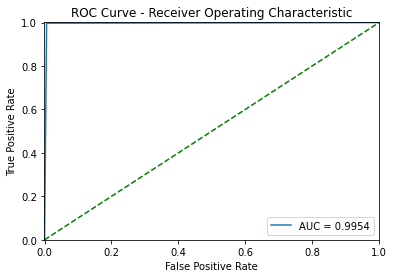


Ensemble['lr', 'rf', 'nn']:

Accuracy: 0.98902
Confusion Matrix:
[[4726   90]
 [  24 5542]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      4816
         1.0       0.98      1.00      0.99      5566

    accuracy                           0.99     10382
   macro avg       0.99      0.99      0.99     10382
weighted avg       0.99      0.99      0.99     10382



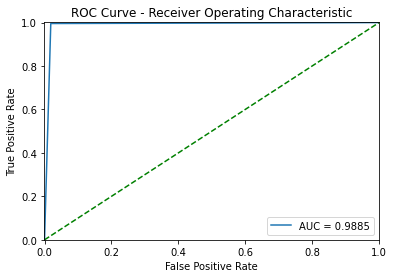


Ensemble['lr', 'xgb', 'rf', 'nn']:

Accuracy: 0.99538
Confusion Matrix:
[[4787   29]
 [  19 5547]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      4816
         1.0       0.99      1.00      1.00      5566

    accuracy                           1.00     10382
   macro avg       1.00      1.00      1.00     10382
weighted avg       1.00      1.00      1.00     10382



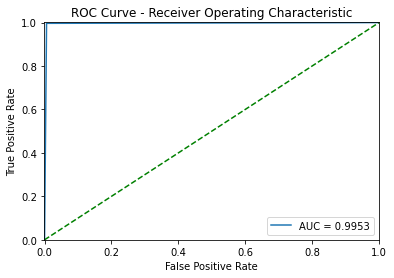

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [41]:
e1 = [("lr", e1_lr), ("xgb", e1_xgboost), ("rf", e1_rf)]
e2 = [("lr", e2_lr), ("rf", e2_rf), ("nn", e2_sknn)]
e3 = [("lr", e3_lr), ("xgb", e3_xgboost), ("rf", e3_rf), ("nn", e3_sknn)]

for e in [e1, e2, e3]:
    print(f"\nEnsemble{[m[0] for m in e]}:\n")
    y_pred, _ = avg_ensemble_predict(e, X_test)
    print_stats(y_test, y_pred)
    drow_roc_curve(y_test, y_pred)